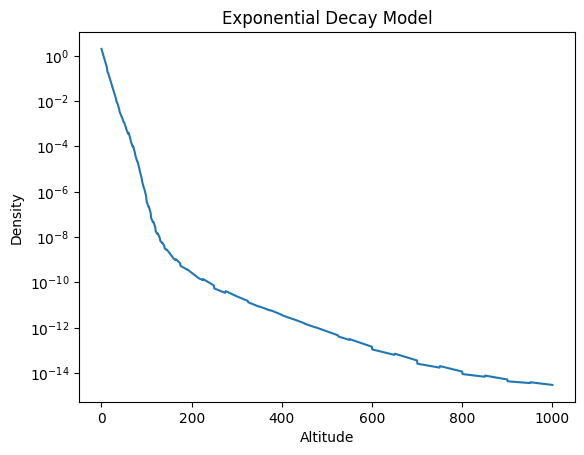

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

atmospheric_table = {'0':[1.225,7.249],
                     '25':[3.899*10**-2,6.349],
                     '30':[1.774*10**-2,6.6882],
                     '40':[3.972*10**-3,7.554],
                     '50':[1.057*10**-3,8.382],
                     '60':[3.206*10**-4,7.714],
                     '70':[8.770*10**-5,6.549],
                     '80':[1.905*10**-5,5.799],
                     '90':[3.396*10**-6,5.382],
                     '100':[5.297*10**-7,5.877],
                     '110':[9.661*10**-8,7.263],
                     '120':[2.438*10**-8,9.473],
                     '130':[8.484*10**-9,12.636],
                     '140':[3.845*10**-9,16.149],
                     '150':[2.070*10**-9,22.523],
                     '180':[5.464*10**-10,27.740],
                     '200':[2.789*10**-10,37.105],
                     '250':[7.248*10**-11,45.546],
                     '300':[2.148*10**-11,53.628],
                     '350':[9.518*10**-12,53.298],
                     '400':[3.725*10**-12,58.515],
                     '450':[1.585*10**-12,60.828],
                     '500':[6.967*10**-13,63.822],
                     '600':[1.454*10**-13,71.835],
                     '700':[3.614*10**-14,88.667],
                     '800':[1.170*10**-14,124.64],
                     '900':[5.245*10**-15,181.05],
                     '1000':[3.019*10**-15,268]
                     }
# display(pd.DataFrame(atmospheric_table).T)

def Density(altitude):
  base_altitudes = [int(i) for i in list(atmospheric_table.keys())]
  sorted_list = sorted(base_altitudes, key=lambda x: abs(x - altitude))
  keys_to_use = sorted_list[:2][::-1]
  base_altitude = keys_to_use[0]
  lower_altitude_key = str(keys_to_use[0])
  higher_altitude_key = str(keys_to_use[1])
  nominal_density, scale_height = atmospheric_table[lower_altitude_key][:2]
  return nominal_density * np.exp((base_altitude - altitude) / scale_height)

example_altitudes = np.linspace(0,1000,1000)
example_densities = [Density(i) for i in example_altitudes]
plt.plot(example_altitudes,example_densities)
plt.title('Exponential Decay Model')
plt.xlabel('Altitude')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

In [4]:
Density(81)

1.8080591517860697e-05

### Setting up the orbit with a drag formula of:
$$ \ddot{r}_{drag} +\frac{\rho}{2 c_b} v^2_{rel} \hat{v}_{rel} = 0$$
$$ \ddot{r}_{gravity} + \frac{\mu}{r^3}\hat{r} = 0$$
where:
$$v_{rel} = v - \omega_{earth}\times r$$
$$v = \dot{r}$$
starting from a circular orbit with:
$$ r_{intial} \in [200,500] + r_{earth}$$
$$ \dot{r}_{intial} = \sqrt{\frac{\mu}{r_{circular}}}$$
Using scipy.integrate system of equations to integrate with:

$$\dot{r}_1 = r_2 $$
$$\dot{r}_2 = -\frac{\rho}{2 c_b} v^2_{rel} \hat{v}_{rel} -\frac{\mu}{r_1^3}\hat{r_1}$$

where $v = r_2$ and we want to find when $r=r_{earth}$

,Unnamed: 0,Sun,Mercury,Venus,Earth,Moon,Mars,Jupiter,Saturn,Uranus,Neptune,Pluto
0,mu,1.327124e+11,22031.78,3.248586e+05,3.986004e+05,4902.800066,4.282837e+04,1.266865e+08,3.793121e+07,5.793951e+06,6.835100e+06,8.696138e+02
1,req,6.960000e+05,2439.70,6.051800e+03,6.378136e+03,1737.400000,3.396190e+03,7.149200e+04,6.026800e+04,2.555900e+04,2.476400e+04,1.195000e+03
2,soi,NaN,112500.00,6.164000e+05,9.166000e+05,NaN,5.774000e+05,4.822300e+07,5.467900e+07,5.179200e+07,8.697500e+07,1.514600e+07
3,avg orbit radius,NaN,57910000.00,1.082041e+08,1.495979e+08,NaN,2.279400e+08,7.783300e+08,1.429400e+09,2.870990e+09,4.504300e+09,5.913520e+09


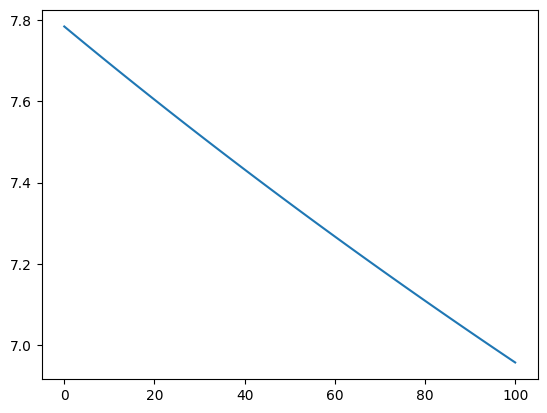

In [20]:
astro_constants = pd.read_csv('AstroConstants.csv')
display(pd.DataFrame(astro_constants))
mu_earth = astro_constants['Earth'][0]
r_earth = astro_constants['Earth'][1]
omega_earth = 0.00003
ballistic_coefficient = .28
def RelativeMotion(t,r_vector):
  r1,r2 = r_vector
  air_density = Density(altitude=r1-r_earth)
  v_relative = r2 - omega_earth * r1
  dr1dt = r2
  dr2dt = -air_density/(2*ballistic_coefficient) * v_relative**2 - mu_earth/r1**2
  drdt = [dr1dt,dr2dt]
  return drdt
time = np.linspace(0,100,100)
r_start = 200 + r_earth
solution = odeint(RelativeMotion,y0=(r_start,(mu_earth/r_start)**0.5),t=time,tfirst=True)
plt.plot(time,solution.T[1])